In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
from pprint import pprint
import re
import json
import gzip
class LTEParser:
    _mapa = {
        "B": "#Bearer",
        "T": "TimeStamp",
        "TX": "Transmission",
        "RX": "Receiver",
        "D": "Delay",
        "ID": "#Packet",
        "DST": "Destiny",
        "SRC": "Source",
        "SIZE": "Size"
    }
    @staticmethod
    def parse(inFile, flowDuration = 100):
        #VIDEO
        videoAverages = []
        videoFairness = []
        videoDelay = []
        videoJitter = []
        videoPLR = []
        #VOICE
        voiceAverages = []
        voiceFairness = []
        voiceDelay = []
        voiceJitter = []
        voicePLR = []
        #INFBUF
        infBufAverages = []
        infBufFairness = []
        infBufDelay = []
        infBufJitter = []
        infBufPLR = []
        #GERAL
        packetLoss = []
        for sfile in inFile:
            content = ""
            print("Opening file: " + sfile)
            with gzip.open(sfile, 'rb') as file:
                content = file.read()
                content = content.decode('utf-8')
            print("Parsing file ...", end="")
            txContent, rxContent = LTEParser._parse(content)
            info = LTEParser.getFairnessIndex(rxContent, flowDuration)
            packetLossInfo = LTEParser.getPacketLossRatio(txContent, rxContent)
            delayInfo = LTEParser.getDelayJitter(rxContent)
            #VIDEO
            videoAverages.append(info['VIDEO']['Average'])
            videoFairness.append(info['VIDEO']['FairnessIndex'])
            videoDelay.append(delayInfo['VIDEO']['Average'])
            videoJitter.append(delayInfo['VIDEO']['StD'])
            videoPLR.append(packetLossInfo[1]['VIDEO'])
            #VOICE
            voiceAverages.append(info['VOIP']['Average'])
            voiceFairness.append(info['VOIP']['FairnessIndex'])
            voiceDelay.append(delayInfo['VOIP']['Average'])
            voiceJitter.append(delayInfo['VOIP']['StD'])
            voicePLR.append(packetLossInfo[1]['VOIP'])
            #INFBUF
            infBufAverages.append(info['INF_BUF']['Average'])
            infBufFairness.append(info['INF_BUF']['FairnessIndex'])
            infBufDelay.append(delayInfo['INF_BUF']['Average'])
            infBufJitter.append(delayInfo['INF_BUF']['StD'])
            infBufPLR.append(packetLossInfo[1]['INF_BUF'])
            #GERAL
            packetLoss.append(packetLossInfo[0])
        return [#VIDEO
                (sum(videoAverages)/len(videoAverages)),
                (sum(videoFairness)/len(videoFairness)),
                (sum(videoDelay)/len(videoDelay)),
                (sum(videoJitter)/len(videoJitter)),
                (sum(videoPLR)/len(videoPLR)),
                #VOICE
                (sum(voiceAverages)/len(voiceAverages)),
                (sum(voiceFairness)/len(voiceFairness)),
                (sum(voiceDelay)/len(voiceDelay)),
                (sum(voiceJitter)/len(voiceJitter)),
                (sum(voicePLR)/len(voicePLR)),
                #INFBUF
                (sum(infBufAverages)/len(infBufAverages)),
                (sum(infBufFairness)/len(infBufFairness)),
                (sum(infBufDelay)/len(infBufDelay)),
                (sum(infBufJitter)/len(infBufJitter)),
                (sum(infBufPLR)/len(infBufPLR)),
                #GERAL
                packetLoss]
    @staticmethod
    def _parse(content):
        txContent = LTEParser.parseTX(content)
        rxContent = LTEParser.parseRX(content)
        print("Done")
        return txContent, rxContent
    
    @staticmethod
    def parseTX(content):
        matches = re.findall("(TX.+)", content)
        if(matches == []):
            raise Exception("No matches in content for TX")
        dictPacketType = {"CBR": [], "VOIP": [], "VIDEO": [], "INF_BUF": [], "WEB": []}
        for match in matches:
            values = match.split(' ')
            tamanho = len(values)
            dic = {}
            for i in range(2, tamanho if tamanho%2==0 else tamanho-1, 2):
                dic[LTEParser._mapa[values[i]]] = values[i+1]
            dic = dict(sorted(dic.items(), key=lambda x: x[0]))
            dictPacketType[values[1]].append(dic)
        return json.loads(json.dumps(dictPacketType))
        
    @staticmethod        
    def parseRX(content):
        matches = re.findall("(RX.+)", content)
        if(matches == []):
            raise Exception("No matches in content for TX")
        dictPacketType = {"CBR": [], "VOIP": [], "VIDEO": [], "INF_BUF": [], "WEB": []}
        for match in matches:
            values = match.split(' ')
            tamanho = len(values)
            dic = {}
            for i in range(2, tamanho if tamanho%2==0 else tamanho-1, 2):
                dic[LTEParser._mapa[values[i]]] = values[i+1]
            dic = dict(sorted(dic.items(), key=lambda x: x[0]))
            dictPacketType[values[1]].append(dic)
        return json.loads(json.dumps(dictPacketType))
    
    @staticmethod
    def getPacketLossRatio(txContent, rxContent):
        dictPacketType = {"CBR": [], "VOIP": [], "VIDEO": [], "INF_BUF": [], "WEB": []}
        tx_pkts = 0
        rx_pkts = 0
        for key in txContent:
            keytx = len(txContent[key])
            tx_pkts += keytx
            keyrx = len(rxContent[key])
            rx_pkts += keyrx
            keyPLR = ((keytx - keyrx) / (keytx if keytx != 0 else 1)) * 100
            dictPacketType[key] = keyPLR
        plr = ((tx_pkts - rx_pkts) / tx_pkts) * 100
        return plr, dictPacketType
    
    @staticmethod
    def getDelayJitter(rxContent):
        delayPerApp = {}
        for app in rxContent:
            delayPerApp[app] = {"Sum": 0, "Average": 0, "StD": 0}
            delayPerApp[app]["Sum"] = sum(float(item["Delay"]) for item in rxContent[app])
            tamanho = len(rxContent[app])
            delayPerApp[app]["Average"] = delayPerApp[app]["Sum"]/tamanho if tamanho != 0 else 0
            delayPerApp[app]["StD"] = sum((float(item["Delay"]) - delayPerApp[app]["Average"])**2 for item in rxContent[app])/ (tamanho - 1) if tamanho != 0 else 0
        return delayPerApp
    
    @staticmethod
    def getGoodput(rxContent, flowDuration):
        gputPerApp = {}
        for app in rxContent:
            gputPerApp[app] = {"Sum": 0, "Average": 0}
            gputPerApp[app]["Sum"] = sum(float(item["Size"])*8 for item in rxContent[app])
            gputPerApp[app]["Average"] = (gputPerApp[app]["Sum"])/flowDuration
        return gputPerApp
    
    @staticmethod
    def getThroughput(rxContent, flowDuration):
        tputPerApp = {}
        for app in rxContent:
            tputPerApp[app] = {"Sum": 0, "Average": 0}
            tputPerApp[app]["Sum"] = sum((float(item["Size"]) + 5)*8 for item in rxContent[app])
            tputPerApp[app]["Average"] = (tputPerApp[app]["Sum"])/flowDuration
        return tputPerApp
    
    @staticmethod
    def getSpectralEff():
        pass
    
    @staticmethod
    def getFairnessIndex(rxContent, flowDuration):
        fairnessPerApp = {}
        for app in rxContent:
            fairnessPerApp[app] = {"Sum": 0, "Average": 0, "SumSquared": 0, "SquaredSum": 0, "FairnessIndex": 0}
            if(len(rxContent[app]) > 0):
                fairnessPerApp[app]["Sum"] = sum(float(item["Size"])*8 for item in rxContent[app])
                fairnessPerApp[app]["Average"] = (fairnessPerApp[app]["Sum"])/flowDuration
                fairnessPerApp[app]["SumSquared"] = sum(pow(float(item["Size"])*8,2) for item in rxContent[app])
                fairnessPerApp[app]["SquaredSum"] = pow(fairnessPerApp[app]["Sum"], 2)
                division = (len(rxContent[app]) * fairnessPerApp[app]["SumSquared"])
                fairnessPerApp[app]["FairnessIndex"] = fairnessPerApp[app]["SquaredSum"] / division if division > 0 else 1
        return fairnessPerApp

In [2]:
base = "../../../Simulations/SingleCell/TRACE"
ext = ".gz"
until = 11
users = 51
files = {1: {30: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
            120: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}},
         2: {30: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
            120: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}},
         3: {30: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
            120: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}},
         4: {30: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
            120: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}},
         5: {30: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
            120: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}},
         6: {30: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []},
            120: {10: [], 20: [], 30: [], 40: [], 50: [], 60: [], 70: [], 80: [], 90: [], 100: []}}}
for sched in range(1,7):
    for ue in range(10, users, 10):
        for vel in [30]:
            for count in range(1,until):
                file = "/SCHED_" + str(sched) + "_UE_" + str(ue) + "_V_" + str(vel) +"_D_0.1_" + str(count)
                filename = base + file + ext
                files[sched][vel][ue].append(filename)

In [3]:
pprint(files)

{1: {30: {10: ['../../../Simulations/SingleCell/TRACE/SCHED_1_UE_10_V_30_D_0.1_1.gz',
               '../../../Simulations/SingleCell/TRACE/SCHED_1_UE_10_V_30_D_0.1_2.gz',
               '../../../Simulations/SingleCell/TRACE/SCHED_1_UE_10_V_30_D_0.1_3.gz',
               '../../../Simulations/SingleCell/TRACE/SCHED_1_UE_10_V_30_D_0.1_4.gz',
               '../../../Simulations/SingleCell/TRACE/SCHED_1_UE_10_V_30_D_0.1_5.gz',
               '../../../Simulations/SingleCell/TRACE/SCHED_1_UE_10_V_30_D_0.1_6.gz',
               '../../../Simulations/SingleCell/TRACE/SCHED_1_UE_10_V_30_D_0.1_7.gz',
               '../../../Simulations/SingleCell/TRACE/SCHED_1_UE_10_V_30_D_0.1_8.gz',
               '../../../Simulations/SingleCell/TRACE/SCHED_1_UE_10_V_30_D_0.1_9.gz',
               '../../../Simulations/SingleCell/TRACE/SCHED_1_UE_10_V_30_D_0.1_10.gz'],
          20: ['../../../Simulations/SingleCell/TRACE/SCHED_1_UE_20_V_30_D_0.1_1.gz',
               '../../../Simulations/SingleCell/TRAC

# 30KM/H

In [4]:
#VIDEO
GPUTSVIDEO = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
FAIRVIDEO = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
DELAYVIDEO = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
JITTERVIDEO = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
PLRVIDEO = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
#VOICE
GPUTSVOICE = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
FAIRVOICE = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
DELAYVOICE = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
JITTERVOICE = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
PLRVOICE = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
#INFBUF
GPUTSINFBUF = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
FAIRINFBUF = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
DELAYINFBUF = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
JITTERINFBUF = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
PLRINFBUF = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
#GERAL
PACKETLOSS = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
for sched in GPUTSVIDEO:
    for ue in range(10, users, 10):
        info = LTEParser.parse(files[sched][30][ue], 100)
        #VIDEO
        GPUTSVIDEO[sched].append(info[0])
        FAIRVIDEO[sched].append(info[1])
        DELAYVIDEO[sched].append(info[2])
        JITTERVIDEO[sched].append(info[3])
        PLRVIDEO[sched].append(info[4])
        #VOICE
        GPUTSVOICE[sched].append(info[5])
        FAIRVOICE[sched].append(info[6])
        DELAYVOICE[sched].append(info[7])
        JITTERVOICE[sched].append(info[8])
        PLRVOICE[sched].append(info[9])
        #INFBUF
        GPUTSINFBUF[sched].append(info[10])
        FAIRINFBUF[sched].append(info[11])
        DELAYINFBUF[sched].append(info[12])
        JITTERINFBUF[sched].append(info[13])
        PLRINFBUF[sched].append(info[14])
        #GERAL
        PACKETLOSS[sched].append(info[15])
    #VIDEO
    GPUTSVIDEO[sched] = np.array(GPUTSVIDEO[sched], dtype=np.float32)
    FAIRVIDEO[sched] = np.array(FAIRVIDEO[sched], dtype=np.float32)
    DELAYVIDEO[sched] = np.array(DELAYVIDEO[sched], dtype = np.float32)
    JITTERVIDEO[sched] = np.array(JITTERVIDEO[sched], dtype = np.float32)
    PLRVIDEO[sched] = np.array(PLRVIDEO[sched], dtype = np.float32)
    #VOICE
    GPUTSVOICE[sched] = np.array(GPUTSVOICE[sched], dtype=np.float32)
    FAIRVOICE[sched] = np.array(FAIRVOICE[sched], dtype=np.float32)
    DELAYVOICE[sched] = np.array(DELAYVOICE[sched], dtype = np.float32)
    JITTERVOICE[sched] = np.array(JITTERVOICE[sched], dtype = np.float32)
    PLRVOICE[sched] = np.array(PLRVOICE[sched], dtype = np.float32)
    #INFBUF
    GPUTSINFBUF[sched] = np.array(GPUTSINFBUF[sched], dtype=np.float32)
    FAIRINFBUF[sched] = np.array(FAIRINFBUF[sched], dtype=np.float32)
    DELAYINFBUF[sched] = np.array(DELAYINFBUF[sched], dtype = np.float32)
    JITTERINFBUF[sched] = np.array(JITTERINFBUF[sched], dtype = np.float32)
    PLRINFBUF[sched] = np.array(PLRINFBUF[sched], dtype = np.float32)
    #GERAL
    PACKETLOSS[sched] = np.array(PACKETLOSS[sched], dtype=np.float32)

Opening file: ../../../Simulations/SingleCell/TRACE/SCHED_1_UE_10_V_30_D_0.1_1.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/TRACE/SCHED_1_UE_10_V_30_D_0.1_2.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/TRACE/SCHED_1_UE_10_V_30_D_0.1_3.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/TRACE/SCHED_1_UE_10_V_30_D_0.1_4.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/TRACE/SCHED_1_UE_10_V_30_D_0.1_5.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/TRACE/SCHED_1_UE_10_V_30_D_0.1_6.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/TRACE/SCHED_1_UE_10_V_30_D_0.1_7.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/TRACE/SCHED_1_UE_10_V_30_D_0.1_8.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/TRACE/SCHED_1_UE_10_V_30_D_0.1_9.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/TRACE/SCHED_1_UE_10_V_30_D_

Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/TRACE/SCHED_2_UE_40_V_30_D_0.1_1.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/TRACE/SCHED_2_UE_40_V_30_D_0.1_2.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/TRACE/SCHED_2_UE_40_V_30_D_0.1_3.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/TRACE/SCHED_2_UE_40_V_30_D_0.1_4.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/TRACE/SCHED_2_UE_40_V_30_D_0.1_5.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/TRACE/SCHED_2_UE_40_V_30_D_0.1_6.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/TRACE/SCHED_2_UE_40_V_30_D_0.1_7.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/TRACE/SCHED_2_UE_40_V_30_D_0.1_8.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/TRACE/SCHED_2_UE_40_V_30_D_0.1_9.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/TRACE/

Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/TRACE/SCHED_4_UE_20_V_30_D_0.1_1.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/TRACE/SCHED_4_UE_20_V_30_D_0.1_2.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/TRACE/SCHED_4_UE_20_V_30_D_0.1_3.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/TRACE/SCHED_4_UE_20_V_30_D_0.1_4.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/TRACE/SCHED_4_UE_20_V_30_D_0.1_5.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/TRACE/SCHED_4_UE_20_V_30_D_0.1_6.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/TRACE/SCHED_4_UE_20_V_30_D_0.1_7.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/TRACE/SCHED_4_UE_20_V_30_D_0.1_8.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/TRACE/SCHED_4_UE_20_V_30_D_0.1_9.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/TRACE/

Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/TRACE/SCHED_5_UE_50_V_30_D_0.1_1.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/TRACE/SCHED_5_UE_50_V_30_D_0.1_2.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/TRACE/SCHED_5_UE_50_V_30_D_0.1_3.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/TRACE/SCHED_5_UE_50_V_30_D_0.1_4.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/TRACE/SCHED_5_UE_50_V_30_D_0.1_5.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/TRACE/SCHED_5_UE_50_V_30_D_0.1_6.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/TRACE/SCHED_5_UE_50_V_30_D_0.1_7.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/TRACE/SCHED_5_UE_50_V_30_D_0.1_8.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/TRACE/SCHED_5_UE_50_V_30_D_0.1_9.gz
Parsing file ...Done
Opening file: ../../../Simulations/SingleCell/TRACE/

# VIDEO GPUT MB/s

In [5]:
MEGAVIDEO = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
for sched in GPUTSVIDEO:
    MEGAVIDEO[sched] = np.true_divide(GPUTSVIDEO[sched], 1e+6)
MEGAVIDEO

{1: array([ 2.457172 ,  4.9126244,  7.3702455,  9.817211 , 12.250678 ],
       dtype=float32),
 2: array([ 2.457172 ,  4.9132814,  7.3620324,  9.799739 , 12.18449  ],
       dtype=float32),
 3: array([ 2.4541457,  4.9102306,  7.357232 ,  9.79214  , 12.169763 ],
       dtype=float32),
 4: array([ 2.4463353,  4.880533 ,  7.31307  ,  9.725667 , 12.131029 ],
       dtype=float32),
 5: array([ 2.457032,  4.907838,  7.364414,  9.796435, 12.174728],
       dtype=float32),
 6: array([ 2.457172,  4.913637,  7.36135 ,  9.797326, 12.15878 ],
       dtype=float32)}

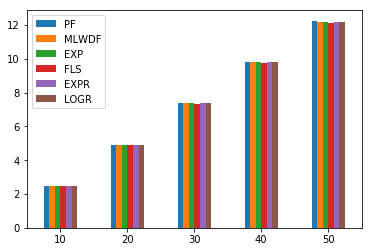

In [6]:
dfGPUTVIDEO = pd.DataFrame({'PF': MEGAVIDEO[1], 'MLWDF': MEGAVIDEO[2], 'EXP': MEGAVIDEO[3],
                       'FLS': MEGAVIDEO[4], 'EXPR': MEGAVIDEO[5], 'LOGR': MEGAVIDEO[6]},
                      index=[10,20,30,40,50])
plot = dfGPUTVIDEO.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/GPUTVideo.pdf", bbox_inches='tight')

In [7]:
dfGPUTVIDEO

,PF,MLWDF,EXP,FLS,EXPR,LOGR
10,2.457172,2.457172,2.454146,2.446335,2.457032,2.457172
20,4.912624,4.913281,4.910231,4.880533,4.907838,4.913637
30,7.370245,7.362032,7.357232,7.313070,7.364414,7.361350
40,9.817211,9.799739,9.792140,9.725667,9.796435,9.797326
50,12.250678,12.184490,12.169763,12.131029,12.174728,12.158780


# Delay Jitter

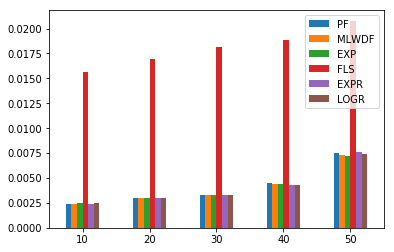

In [8]:
dfDELAYVIDEO = pd.DataFrame({'PF': DELAYVIDEO[1], 'MLWDF': DELAYVIDEO[2], 'EXP': DELAYVIDEO[3],
                            'FLS': DELAYVIDEO[4], 'EXPR': DELAYVIDEO[5], 'LOGR': DELAYVIDEO[6]},
                           index=[10,20,30,40,50])
plot = dfDELAYVIDEO.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/DelayVideoPF.pdf", bbox_inches='tight')

In [ ]:
dfDELAYVIDEO = pd.DataFrame({'MLWDF': DELAYVIDEO[2], 'EXP': DELAYVIDEO[3],
                            'FLS': DELAYVIDEO[4], 'EXPR': DELAYVIDEO[5], 'LOGR': DELAYVIDEO[6]},
                           index=[10,20,30,40,50])
plot = dfDELAYVIDEO.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/DelayVideo.pdf", bbox_inches='tight')

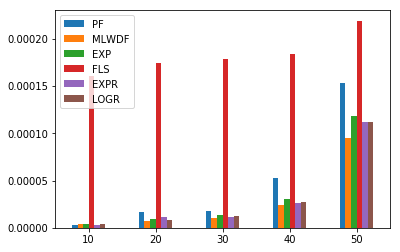

In [9]:
dfJITTERVIDEO = pd.DataFrame({'PF': JITTERVIDEO[1], 'MLWDF': JITTERVIDEO[2], 'EXP': JITTERVIDEO[3],
                            'FLS': JITTERVIDEO[4], 'EXPR': JITTERVIDEO[5], 'LOGR': JITTERVIDEO[6]},
                           index=[10,20,30,40,50])
plot = dfJITTERVIDEO.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/JitterVideoPF.pdf", bbox_inches='tight')

In [ ]:
dfJITTERVIDEO = pd.DataFrame({'MLWDF': JITTERVIDEO[2], 'EXP': JITTERVIDEO[3],
                            'FLS': JITTERVIDEO[4], 'EXPR': JITTERVIDEO[5], 'LOGR': JITTERVIDEO[6]},
                           index=[10,20,30,40,50])
plot = dfJITTERVIDEO.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/JitterVideo.pdf", bbox_inches='tight')

# VIDEO FAIRNESS

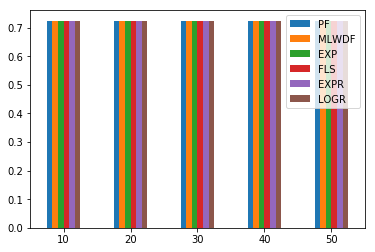

In [10]:
dfFAIRVIDEO = pd.DataFrame({'PF': FAIRVIDEO[1], 'MLWDF': FAIRVIDEO[2], 'EXP': FAIRVIDEO[3],
                            'FLS': FAIRVIDEO[4], 'EXPR': FAIRVIDEO[5], 'LOGR': FAIRVIDEO[6]},
                           index=[10,20,30,40,50])
plot = dfFAIRVIDEO.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/FairnessVideo.pdf", bbox_inches='tight')

In [ ]:
dfFAIRVIDEO

# VIDEO PLR

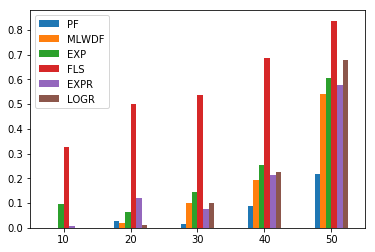

In [11]:
dfPLRVIDEO = pd.DataFrame({'PF': PLRVIDEO[1], 'MLWDF': PLRVIDEO[2], 'EXP': PLRVIDEO[3],
                            'FLS': PLRVIDEO[4], 'EXPR': PLRVIDEO[5], 'LOGR': PLRVIDEO[6]},
                           index=[10,20,30,40,50])
plot = dfPLRVIDEO.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/PacketLossVideo.pdf", bbox_inches='tight')

# VOIP GPUT MB/s

In [ ]:
MEGAVOIP = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
for sched in GPUTSVOICE:
    MEGAVOIP[sched] = np.true_divide(GPUTSVOICE[sched], 8)
MEGAVOIP

In [ ]:
dfGPUTVOICE = pd.DataFrame({'PF': MEGAVOIP[1], 'MLWDF': MEGAVOIP[2], 'EXP': MEGAVOIP[3],
                       'FLS': MEGAVOIP[4], 'EXPR': MEGAVOIP[5], 'LOGR': MEGAVOIP[6]},
                      index=[20,30,40,50,60,70,80,90,100])
plot = dfGPUTVOICE.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/GPUTVoIP.pdf", bbox_inches='tight')

In [ ]:
dfGPUTVOICE

# Delay Jitter

In [ ]:
dfDELAYVOICE = pd.DataFrame({'PF': DELAYVOICE[1], 'MLWDF': DELAYVOICE[2], 'EXP': DELAYVOICE[3],
                            'FLS': DELAYVOICE[4], 'EXPR': DELAYVOICE[5], 'LOGR': DELAYVOICE[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfDELAYVOICE.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/DelayVoIPPF.pdf", bbox_inches='tight')

In [ ]:
dfDELAYVOICE = pd.DataFrame({'MLWDF': DELAYVOICE[2], 'EXP': DELAYVOICE[3],
                            'FLS': DELAYVOICE[4], 'EXPR': DELAYVOICE[5], 'LOGR': DELAYVOICE[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfDELAYVOICE.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/DelayVoIP.pdf", bbox_inches='tight')

In [ ]:
dfJITTERVOICE = pd.DataFrame({'PF': JITTERVOICE[1], 'MLWDF': JITTERVOICE[2], 'EXP': JITTERVOICE[3],
                            'FLS': JITTERVOICE[4], 'EXPR': JITTERVOICE[5], 'LOGR': JITTERVOICE[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfJITTERVOICE.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/JitterVoIPPF.pdf", bbox_inches='tight')

In [ ]:
dfJITTERVOICE = pd.DataFrame({'MLWDF': JITTERVOICE[2], 'EXP': JITTERVOICE[3],
                            'FLS': JITTERVOICE[4], 'EXPR': JITTERVOICE[5], 'LOGR': JITTERVOICE[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfJITTERVOICE.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/JitterVoIP.pdf", bbox_inches='tight')

# VOICE PLR

In [ ]:
dfPLRVOICE = pd.DataFrame({'PF': PLRVOICE[1], 'MLWDF': PLRVOICE[2], 'EXP': PLRVOICE[3],
                            'FLS': PLRVOICE[4], 'EXPR': PLRVOICE[5], 'LOGR': PLRVOICE[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfPLRVOICE.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/PacketLossVoice.pdf", bbox_inches='tight')

# INF BUF

In [ ]:
MEGAINFBUF = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
for sched in GPUTSINFBUF:
    MEGAINFBUF[sched] = np.true_divide(GPUTSINFBUF[sched], 8)
MEGAINFBUF

In [ ]:
dfGPUTINFBUF = pd.DataFrame({'PF': MEGAINFBUF[1], 'MLWDF': MEGAINFBUF[2], 'EXP': MEGAINFBUF[3],
                       'FLS': MEGAINFBUF[4], 'EXPR': MEGAINFBUF[5], 'LOGR': MEGAINFBUF[6]},
                      index=[20,30,40,50,60,70,80,90,100])
plot = dfGPUTINFBUF.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/GPUTInfBuf.pdf", bbox_inches='tight')

In [ ]:
dfGPUTINFBUF

# Delay Jitter

In [ ]:
dfDELAYINFBUF = pd.DataFrame({'PF': DELAYINFBUF[1], 'MLWDF': DELAYINFBUF[2], 'EXP': DELAYINFBUF[3],
                            'FLS': DELAYINFBUF[4], 'EXPR': DELAYINFBUF[5], 'LOGR': DELAYINFBUF[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfDELAYINFBUF.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/DelayINFBUFPF.pdf", bbox_inches='tight')

In [ ]:
dfDELAYINFBUF = pd.DataFrame({'MLWDF': DELAYINFBUF[2], 'EXP': DELAYINFBUF[3],
                            'FLS': DELAYINFBUF[4], 'EXPR': DELAYINFBUF[5], 'LOGR': DELAYINFBUF[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfDELAYINFBUF.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/DelayInfBuf.pdf", bbox_inches='tight')

In [ ]:
dfJITTERINFBUF = pd.DataFrame({'PF': JITTERINFBUF[1], 'MLWDF': JITTERINFBUF[2], 'EXP': JITTERINFBUF[3],
                            'FLS': JITTERINFBUF[4], 'EXPR': JITTERINFBUF[5], 'LOGR': JITTERINFBUF[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfJITTERINFBUF.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/JitterInfBufPF.pdf", bbox_inches='tight')

In [ ]:
dfJITTERINFBUF = pd.DataFrame({'MLWDF': JITTERINFBUF[2], 'EXP': JITTERINFBUF[3],
                            'FLS': JITTERINFBUF[4], 'EXPR': JITTERINFBUF[5], 'LOGR': JITTERINFBUF[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfJITTERINFBUF.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/JitterInfBuf.pdf", bbox_inches='tight')

# VOICE PLR

In [ ]:
dfPLRINFBUF = pd.DataFrame({'PF': PLRINFBUF[1], 'MLWDF': PLRINFBUF[2], 'EXP': PLRINFBUF[3],
                            'FLS': PLRINFBUF[4], 'EXPR': PLRINFBUF[5], 'LOGR': PLRINFBUF[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfPLRINFBUF.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/PacketLossInfBuf.pdf", bbox_inches='tight')

# Loss Ratio

In [ ]:
averagePacketLoss = {}
for key in PACKETLOSS:
    averagePacketLoss[key] = []
    for i in range(0, 9):
        average = sum(PACKETLOSS[key][i])/len(PACKETLOSS[key][i])         
        averagePacketLoss[key].append(average)

In [ ]:
dfLossRatio = pd.DataFrame({'PF': averagePacketLoss[1], 'MLWDF': averagePacketLoss[2], 'EXP': averagePacketLoss[3],
                            'FLS': averagePacketLoss[4], 'EXPR': averagePacketLoss[5], 'LOGR': averagePacketLoss[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfLossRatio.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/PacketLossRatio.pdf", bbox_inches='tight')

In [ ]:
dfLossRatio

# 120 KM/H

In [ ]:
GPUTSVIDEO120 = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
FAIRVIDEO120 = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
DELAYVIDEO120 = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
JITTERVIDEO120 = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
GPUTSVOICE120 = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
FAIRVOICE120 = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
DELAYVOICE120 = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
JITTERVOICE120 = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
PACKETLOSS120 = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
for sched in GPUTSVIDEO:
    for ue in range(20, 101, 10):
        info = LTEParser.parse(files[sched][120][ue], 100)
        GPUTSVIDEO120[sched].append(info[0])
        FAIRVIDEO120[sched].append(info[1])
        DELAYVIDEO120[sched].append(info[2])
        JITTERVIDEO120[sched].append(info[3])
        GPUTSVOICE120[sched].append(info[4])
        FAIRVOICE120[sched].append(info[5])
        DELAYVOICE120[sched].append(info[6])
        JITTERVOICE120[sched].append(info[7])
        PACKETLOSS120[sched].append(info[8])
    GPUTSVIDEO120[sched] = np.array(GPUTSVIDEO120[sched], dtype=np.float32)
    FAIRVIDEO120[sched] = np.array(FAIRVIDEO120[sched], dtype=np.float32)
    DELAYVIDEO120[sched] = np.array(DELAYVIDEO120[sched], dtype = np.float32)
    JITTERVIDEO120[sched] = np.array(JITTERVIDEO120[sched], dtype = np.float32)
    GPUTSVOICE120[sched] = np.array(GPUTSVOICE120[sched], dtype=np.float32)
    FAIRVOICE120[sched] = np.array(FAIRVOICE120[sched], dtype=np.float32)
    DELAYVOICE120[sched] = np.array(DELAYVOICE120[sched], dtype = np.float32)
    JITTERVOICE120[sched] = np.array(JITTERVOICE120[sched], dtype = np.float32)
    PACKETLOSS120[sched] = np.array(PACKETLOSS120[sched], dtype=np.float32)

# VIDEO GPUT MB/s

In [ ]:
MEGAVIDEO120 = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
for sched in GPUTSVIDEO120:
    MEGAVIDEO120[sched] = np.true_divide(GPUTSVIDEO120[sched], 8)
MEGAVIDEO120

In [ ]:
dfGPUTVIDEO120 = pd.DataFrame({'PF': MEGAVIDEO120[1], 'MLWDF': MEGAVIDEO120[2], 'EXP': MEGAVIDEO120[3],
                       'FLS': MEGAVIDEO120[4], 'EXPR': MEGAVIDEO120[5], 'LOGR': MEGAVIDEO120[6]},
                      index=[20,30,40,50,60,70,80,90,100])
plot = dfGPUTVIDEO120.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/GPUTVideo120.pdf", bbox_inches='tight')

In [ ]:
dfGPUTVIDEO120

# Delay Jitter

In [ ]:
dfDELAYVIDEO120 = pd.DataFrame({'PF': DELAYVIDEO120[1], 'MLWDF': DELAYVIDEO120[2], 'EXP': DELAYVIDEO120[3],
                            'FLS': DELAYVIDEO120[4], 'EXPR': DELAYVIDEO120[5], 'LOGR': DELAYVIDEO120[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfDELAYVIDEO120.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/DelayVideoPF120.pdf", bbox_inches='tight')

In [ ]:
dfDELAYVIDEO120 = pd.DataFrame({'MLWDF': DELAYVIDEO120[2], 'EXP': DELAYVIDEO120[3],
                            'FLS': DELAYVIDEO120[4], 'EXPR': DELAYVIDEO120[5], 'LOGR': DELAYVIDEO120[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfDELAYVIDEO120.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/DelayVideo120.pdf", bbox_inches='tight')

In [ ]:
dfJITTERVIDEO120 = pd.DataFrame({'PF': JITTERVIDEO120[1], 'MLWDF': JITTERVIDEO120[2], 'EXP': JITTERVIDEO120[3],
                            'FLS': JITTERVIDEO120[4], 'EXPR': JITTERVIDEO120[5], 'LOGR': JITTERVIDEO120[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfJITTERVIDEO120.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/JitterVideoPF120.pdf", bbox_inches='tight')

In [ ]:
dfJITTERVIDEO120 = pd.DataFrame({'MLWDF': JITTERVIDEO120[2], 'EXP': JITTERVIDEO120[3],
                            'FLS': JITTERVIDEO120[4], 'EXPR': JITTERVIDEO120[5], 'LOGR': JITTERVIDEO120[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfJITTERVIDEO120.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/JitterVideo120.pdf", bbox_inches='tight')

# VIDEO FAIRNESS

In [ ]:
dfFAIRVIDEO120 = pd.DataFrame({'PF': FAIRVIDEO120[1], 'MLWDF': FAIRVIDEO120[2], 'EXP': FAIRVIDEO120[3],
                            'FLS': FAIRVIDEO120[4], 'EXPR': FAIRVIDEO120[5], 'LOGR': FAIRVIDEO120[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfFAIRVIDEO120.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/FairnessVideo120.pdf", bbox_inches='tight')

In [ ]:
dfFAIRVIDEO120

# VOIP GPUT MB/s

In [ ]:
MEGAVOIP120 = {1: [], 2: [], 3: [], 4: [], 5: [], 6: []}
for sched in GPUTSVOICE120:
    MEGAVOIP120[sched] = np.true_divide(GPUTSVOICE120[sched], 8)
MEGAVOIP120

In [ ]:
dfGPUTVOICE120 = pd.DataFrame({'PF': MEGAVOIP120[1], 'MLWDF': MEGAVOIP120[2], 'EXP': MEGAVOIP120[3],
                       'FLS': MEGAVOIP120[4], 'EXPR': MEGAVOIP120[5], 'LOGR': MEGAVOIP120[6]},
                      index=[20,30,40,50,60,70,80,90,100])
plot = dfGPUTVOICE120.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/GPUTVoIP120.pdf", bbox_inches='tight')

In [ ]:
dfGPUTVOICE120

# Delay Jitter

In [ ]:
dfDELAYVOICE120 = pd.DataFrame({'PF': DELAYVOICE120[1], 'MLWDF': DELAYVOICE120[2], 'EXP': DELAYVOICE120[3],
                            'FLS': DELAYVOICE120[4], 'EXPR': DELAYVOICE120[5], 'LOGR': DELAYVOICE120[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfDELAYVOICE120.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/DelayVoIPPF120.pdf", bbox_inches='tight')

In [ ]:
dfDELAYVOICE120 = pd.DataFrame({'MLWDF': DELAYVOICE120[2], 'EXP': DELAYVOICE120[3],
                            'FLS': DELAYVOICE120[4], 'EXPR': DELAYVOICE120[5], 'LOGR': DELAYVOICE120[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfDELAYVOICE120.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/DelayVoIP120.pdf", bbox_inches='tight')

In [ ]:
dfJITTERVOICE120 = pd.DataFrame({'PF': JITTERVOICE120[1], 'MLWDF': JITTERVOICE120[2], 'EXP': JITTERVOICE120[3],
                            'FLS': JITTERVOICE120[4], 'EXPR': JITTERVOICE120[5], 'LOGR': JITTERVOICE120[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfJITTERVOICE120.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/JitterVoIPPF120.pdf", bbox_inches='tight')

In [ ]:
dfJITTERVOICE120 = pd.DataFrame({'MLWDF': JITTERVOICE120[2], 'EXP': JITTERVOICE120[3],
                            'FLS': JITTERVOICE120[4], 'EXPR': JITTERVOICE120[5], 'LOGR': JITTERVOICE120[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfJITTERVOICE120.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/JitterVoIP120.pdf", bbox_inches='tight')

# Loss Ratio

In [ ]:
averagePacketLoss120 = {}
for key in PACKETLOSS120:
    averagePacketLoss120[key] = []
    for i in range(0, 9):
        average = sum(PACKETLOSS120[key][i])/len(PACKETLOSS120[key][i])         
        averagePacketLoss120[key].append(average)

In [ ]:
dfLossRatio120 = pd.DataFrame({'PF': averagePacketLoss120[1], 'MLWDF': averagePacketLoss120[2], 'EXP': averagePacketLoss120[3],
                            'FLS': averagePacketLoss120[4], 'EXPR': averagePacketLoss120[5], 'LOGR': averagePacketLoss120[6]},
                           index=[20,30,40,50,60,70,80,90,100])
plot = dfLossRatio120.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig("./pdfs/PacketLossRatio120.pdf", bbox_inches='tight')

In [ ]:
dfLossRatio120